## 7️⃣ Error Analysis


In [33]:
# Load libraries
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import pickle
import statsmodels.api as sm
import statsmodels.stats.diagnostic as ss
import scipy.stats as stats

# Import helper function made ad-hoc
# from R2_functions import univariate_outlier_removal
from R3_functions import chain_snap
# from R4_functions import regression_report

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, learning_curve

# Set random seed
np.random.seed(42)

**1.** Load the train and validation datasets used in section 5: 

Create a baseline model and carry out a data cleaning procedure based on the previous findings; 

In [2]:
DATA_TRAIN_PATH = os.path.join("data", "data_train_processed.parquet")
DATA_VAL_PATH = os.path.join("data", "data_val_processed.parquet")

In [3]:
# Load train and validation set

data_train = (
    pd.read_parquet(DATA_TRAIN_PATH)
    # drop Address and Zipcode as they are not useful
    .drop(columns=["Address", "Zip"])
    # Drop Lat and Lon
    .drop(columns=["Lat", "Lon"])
    # Drop Delivery Area as it contains too many categories
    .drop(columns=["Delivery_area"])
    # Discard all rows with values Price > 2M
    .loc[lambda x: x.Price < 2e6]
    # Double check nan values as sklearn does not like them
    .pipe(chain_snap, fn=lambda x: x.shape, msg="• Size dataframe")
    .pipe(
        chain_snap, fn=lambda x: x.isna().sum().sum(), msg="• Count NaNs post processing"
    )
    .pipe(chain_snap, fn=lambda x: display(x.head(2)), msg="• Train data head")
)

data_val = (
    pd.read_parquet(DATA_VAL_PATH)
    # drop Address and Zipcode as they are not useful
    .drop(columns=["Address", "Zip"])
    # Drop Lat and Lon
    .drop(columns=["Lat", "Lon"])
    # Drop Delivery Area as it contains too many categories
    .drop(columns=["Delivery_area"])
    # Discard all rows with values Price > 2M
    .loc[lambda x: x.Price < 2e6]
    # Double check nan values as sklearn does not like them
    .pipe(
        chain_snap, fn=lambda x: x.isna().sum().sum(), msg="• Count NaNs post processing"
    )
    .pipe(chain_snap, fn=lambda x: x.shape, msg="• Size dataframe")
    .pipe(chain_snap, fn=lambda x: display(x.head(2)), msg="• Validation data head")
)

# let's consider Price and log(Price) as target. Depending on the model we will use one or the other
TARGET = ["Price", "log(Price)"]

• Size dataframe: (543, 15)
• Count NaNs post processing: 0


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,635000.0,81.0,3.0,13.36138,4.394449,1.098612,1078,0,7,8,27.0,3.295837,3.317122,3.346089,0.031533
1,400000.0,61.0,2.0,12.89922,4.110874,0.693147,1057,0,5,7,30.5,3.417727,1.947822,2.348155,0.036792


• Train data head: None
• Count NaNs post processing: 0
• Size dataframe: (181, 15)


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.0,68,3,12.959844,4.219508,1.098612,1098,0,9,8,22.666667,3.120895,3.606198,4.174069,0.071974
1,285000.0,96,4,12.560244,4.564348,1.386294,1104,1,0,4,24.000000,3.178054,7.350449,8.209335,0.135124


• Validation data head: None


In [4]:
# split train and validation set into X and Y: Note that Y_train and Y_val contrains both Price and log(Price)
X_train, Y_train = data_train.drop(TARGET, axis=1), data_train[TARGET]
X_val, Y_val = data_val.drop(TARGET, axis=1), data_val[TARGET]

**2.** Load the best estimator which has been stored as a pickle file. 

In [5]:
# Get list of folder in artifacts
artifacts_filelist = os.listdir("artifacts")

# Select the folder name in list which contains the string "Ridge"
Ridge_path = [s for s in artifacts_filelist if "Ridge" in s][0]

Ridge_filelist = os.listdir(os.path.join("artifacts", Ridge_path))

#Load the .pkl file to retrieve the best performed model
Ridge_pkl_file = [file for file in Ridge_filelist if file.endswith('.pkl')][0]

# Use full path to load the .pkl file 
pkl_file_path = os.path.join("artifacts",Ridge_path, Ridge_pkl_file)

# Loading the model from .pkl file
if os.path.exists(pkl_file_path):
    with open(pkl_file_path, "rb") as f:
        candidate_model = pickle.load(f)
        print("• Model loaded successfully from:", pkl_file_path)
else:
    print(f"• File not found: {pkl_file_path}")

candidate_model

• Model loaded successfully from: artifacts/2024-03-30-15-35-49_Ridge/Ridge.pkl


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('Ridge', Ridge(alpha=0.2535151515151515))])

In [6]:
# Select the file name in list which contains the string "performance"
Ridge_performance_file = [s for s in Ridge_filelist if "performance" in s][0]

performance_file = os.path.join("artifacts", Ridge_path, Ridge_performance_file)

print("•  Loading baseline performance file from: \n ", performance_file)

# Load csv file. Note. We apply reset_index().set_index() to be able to merge the dataframe afterwards
df_Ridge = (
    pd.read_csv(performance_file, index_col=0)
    .reset_index()
    .set_index(["model", "metrics"])
)

display(df_Ridge)


•  Loading baseline performance file from: 
  artifacts/2024-03-30-15-35-49_Ridge/Ridge_performance.csv


in-sample  out-of-sample  Difference (%)  \
model metrics                                                         
Ridge r-squared                0.840          0.777       -8.108108   
      explained variance       0.841          0.783       -7.407407   
      RMSE                127800.591     160521.179       20.383969   
      MAE                  76344.930      93887.806       18.684936   
      max error           942098.599    1031360.528        8.654775   

                                             Description  
model metrics                                             
Ridge r-squared             Coefficient of Determination  
      explained variance        Explained Variance Score  
      RMSE                Root Mean Squared Error (RMSE)  
      MAE                      Mean Absolute Error (MAE)  
      max error               The maximum residual error

In [7]:
# Select the file name in list which contains the string "metadata"
Ridge_metadata_file = [file for file in Ridge_filelist if "metadata" in file][0]

# Use full path to load the metadata file
metadata_file_path = os.path.join("artifacts",Ridge_path, Ridge_metadata_file)

# Reading the metadata from .md file
if os.path.exists(metadata_file_path):
    with open(metadata_file_path, "r") as f:
        metadata = f.read()
        print("• Metadata loaded successfully from:", metadata_file_path)
        # If you need to print metadata uncomment the line below
        # print(metadata)
else:
    print(f"• File not found: {metadata_file_path}")
    
print(metadata)

• Metadata loaded successfully from: artifacts/2024-03-30-15-35-49_Ridge/Ridge_metadata.md

---
library_name: sklearn
tags:
- Dutch house price prediction
- tabular-regression
license: NA
datasets:
- data/data_train_processed.parquet
- data/data_val_processed.parquet
model: 
- 'ridge regression'
metrics:
- 'r-squared'
features:
- ['log(Area)', 'log(Room)', 'log(AR-ratio)', 'Manhattan_distance', 'Region', 'Location']
target:
- log(Price)
additional_information: 
- Dataset is bounded to samples with price < 2M
- The Dataset contains only houses from Amsterdam
- IMPORTANT: this model is not production ready
---



**Case: Regression problem**

When dealing with a regression problem, one should analyse the residuals, which are the difference between the predicted and observed values of the dependent variable (target) and subsequently:

**•** Plot the residuals versus the fitted values, and determine qualitatively any phenomenon of [heteroskedasticity](https://www.displayr.com/what-is-heteroscedasticity/#:~:text=The%20most%20widely%20used%20test,used%20in%20the%20original%20model.)

🧑‍🔬 To get a quantitative assessment of heteroskedasticity use the [*Breusch-Pagan test*](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

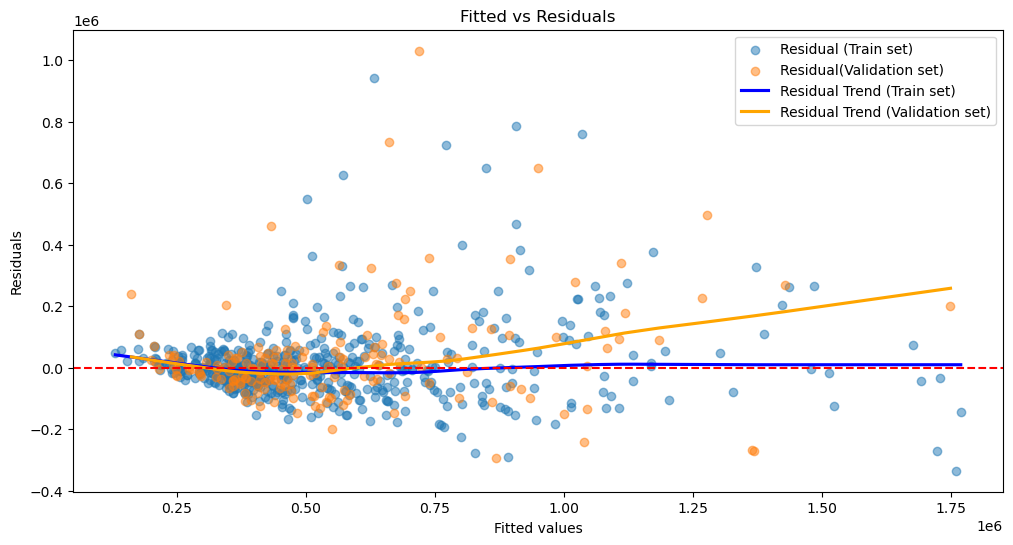

In [8]:
warnings.filterwarnings("ignore")

# Compute fitted values for Ridge model on training set (log scale)
Y_train["fitted"] = candidate_model.predict(X_train)

# Back transform log(Price) to Price for fitted values only
Y_train["fitted"] = np.exp(Y_train["fitted"])

# Compute residuals for Ridge model on training set (log scale)
Y_train["residuals"] = Y_train["Price"] - Y_train["fitted"]

# Compute fitted values for Ridge model on validation set (log scale)
Y_val["fitted"] = candidate_model.predict(X_val)

# Back transform log(Price) to Price for fitted values only
Y_val["fitted"] = np.exp(Y_val["fitted"])

# Compute residuals for Ridge model on validation set (log scale)
Y_val["residuals"] = Y_val["Price"] - Y_val["fitted"]

# Plot fitted vs residual plot for Ridge model
plt.figure(figsize=(12, 6))
plt.scatter(Y_train["fitted"], Y_train["residuals"], label="Residual (Train set)", alpha=0.5)
plt.scatter(Y_val["fitted"], Y_val["residuals"], label="Residual(Validation set)", alpha=0.5)

# Add residual trend line fitting the residuals
# Fit a regression line to the residuals of the training data
sns.regplot(x=Y_train["fitted"], y=Y_train["residuals"], scatter=False, color="blue", lowess=True, label='Residual Trend (Train set)')
# Fit a regression line to the residuals of the validation data
sns.regplot(x=Y_val["fitted"], y=Y_val["residuals"], scatter=False, color="orange", lowess=True, label='Residual Trend (Validation set)')

# Add horizontal line at y=0
plt.axhline(0, color="red", linestyle="--")

# Add legend to the plot
plt.legend()

# Label the axes and the plot
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residuals")

# Show the plot
plt.show()


**•** Plot the distribution of the residuals and measure the mean and the residual standard error. Contextualize these values and assess if they are acceptable using business knowledge.

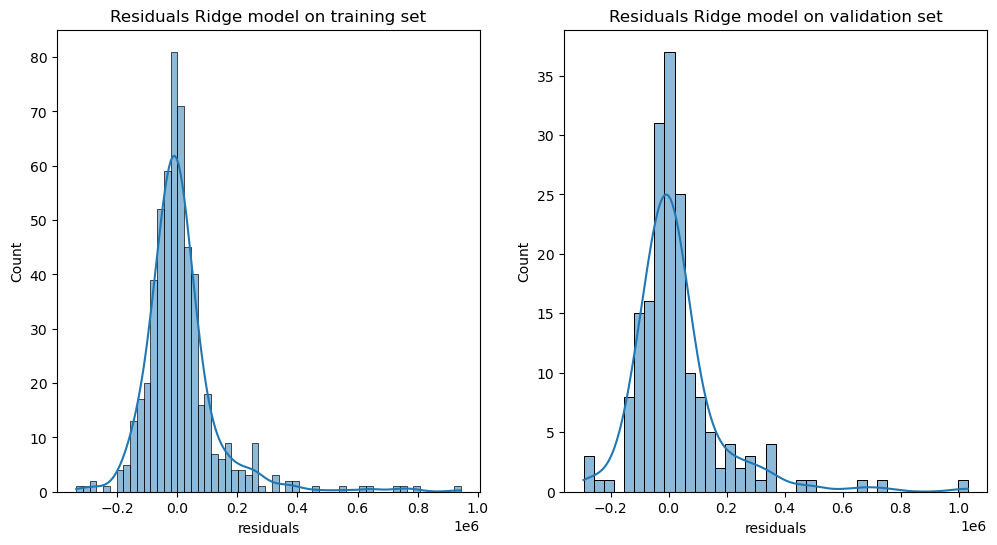

In [9]:
# Plot residuals for Ridge model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(Y_train["residuals"], kde=True)
plt.title("Residuals Ridge model on training set")
plt.subplot(1, 2, 2)
sns.histplot(Y_val["residuals"], kde=True)
plt.title("Residuals Ridge model on validation set")
plt.show()

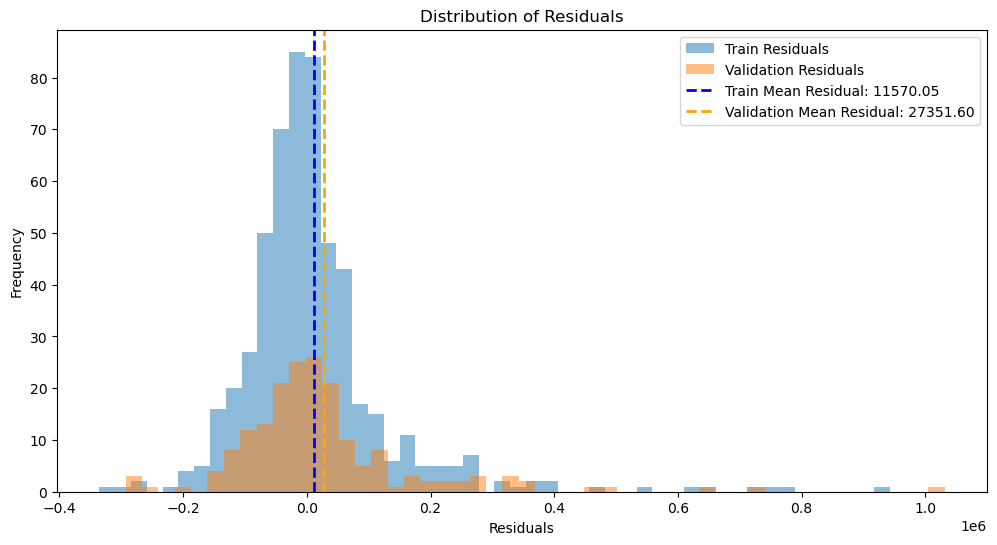

• Train Residual Mean: 11570.05, Train Residual Standard Error: 5466.96
• Validation Residual Mean: 27351.60, Validation Residual Standard Error: 11789.58


In [10]:
# Calculate the mean and standard error (standard deviation of the residuals / sqrt(n)) for training residuals
train_residual_mean = np.mean(Y_train["residuals"])
train_residual_standard_error = np.std(Y_train["residuals"], ddof=1) / np.sqrt(len(Y_train["residuals"]))

# Calculate the mean and standard error for validation residuals
val_residual_mean = np.mean(Y_val["residuals"])
val_residual_standard_error = np.std(Y_val["residuals"], ddof=1) / np.sqrt(len(Y_val["residuals"]))

# Plotting the distribution of the residuals for training and validation sets
plt.figure(figsize=(12,6))

# Histogram for training residuals
plt.hist(Y_train["residuals"], bins=50, alpha=0.5, label='Train Residuals')

# Histogram for validation residuals
plt.hist(Y_val["residuals"], bins=50, alpha=0.5, label='Validation Residuals')

# Plotting the mean of the residuals as a vertical line
plt.axvline(train_residual_mean, color='blue', linestyle='dashed', linewidth=2, label=f'Train Mean Residual: {train_residual_mean:.2f}')
plt.axvline(val_residual_mean, color='orange', linestyle='dashed', linewidth=2, label=f'Validation Mean Residual: {val_residual_mean:.2f}')

# Add legends and labels
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

# Display the plots
plt.show()

# Print out the mean and standard error of the residuals
print(f"• Train Residual Mean: {train_residual_mean:.2f}, Train Residual Standard Error: {train_residual_standard_error:.2f}")
print(f"• Validation Residual Mean: {val_residual_mean:.2f}, Validation Residual Standard Error: {val_residual_standard_error:.2f}")


In [11]:
# define features to be used in the model
features = ['log(Area)', 'log(Room)', 'log(AR-ratio)', 'Manhattan_distance', 'Region', 'Location']

## testing the residuals for homoskedasticity in training set##
# Add a constant to account for the intercept
X_train_with_constant = sm.add_constant(X_train[features])

# Perform the Breusch-Pagan test
breuschpagan = ss.het_breuschpagan(Y_train["residuals"], X_train_with_constant, robust=True)

print(f"F-value: {breuschpagan[2]:.2f}")
print(f"p-value: {breuschpagan[3]:.3f}")

alpha = 0.05
if breuschpagan[3] <= alpha:
    print("• The result suggests that the error term is heteroskedastic.")
else:
    print("• The result suggests that the error term is homoskedastic.")


F-value: 6.70
p-value: 0.000
• The result suggests that the error term is heteroskedastic.


In [12]:
## testing the residuals for homoskedasticity in training set##
# Add a constant to account for the intercept
X_val_with_constant = sm.add_constant(X_val[features])

# Perform the Breusch-Pagan test
breuschpagan = ss.het_breuschpagan(Y_val["residuals"], X_val_with_constant, robust=True)

print(f"F-value: {breuschpagan[2]:.2f}")
print(f"p-value: {breuschpagan[3]:.3f}")

alpha = 0.05
if breuschpagan[3] <= alpha:
    print("• The result suggests that the error term is heteroskedastic.")
else:
    print("• The result suggests that the error term is homoskedastic.")

F-value: 3.27
p-value: 0.008
• The result suggests that the error term is heteroskedastic.


**•** Check high residual values, which indicate a poor prediction, and try to spot any pattern by analyzing the corresponding input values. Investigate the distribution of the model input (features) and apply statistical tests by comparing outliers versus non-outlier values.

Training Set Analysis


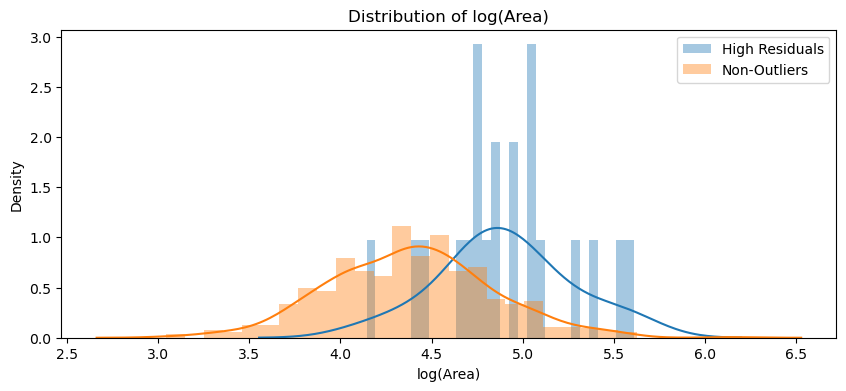

Feature: log(Area), KS Statistic: 0.602, P-Value: 0.000


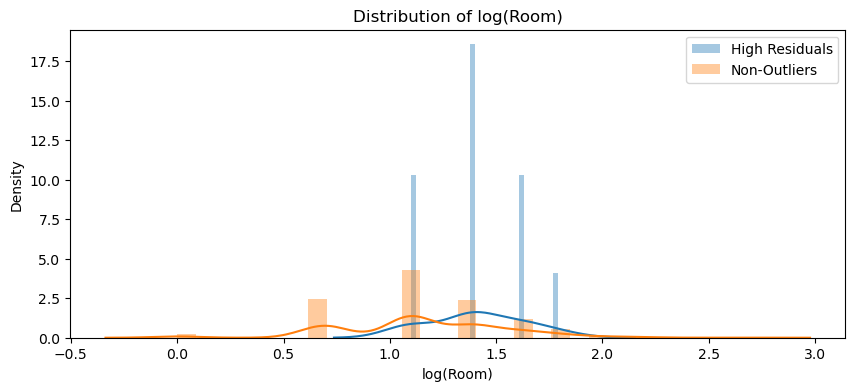

Feature: log(Room), KS Statistic: 0.375, P-Value: 0.005


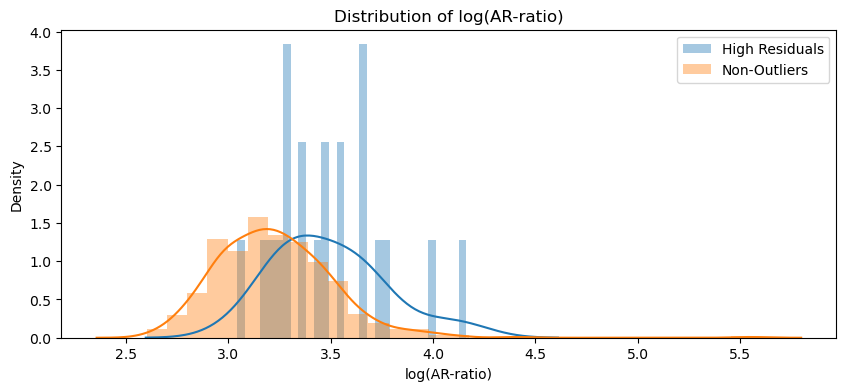

Feature: log(AR-ratio), KS Statistic: 0.443, P-Value: 0.000


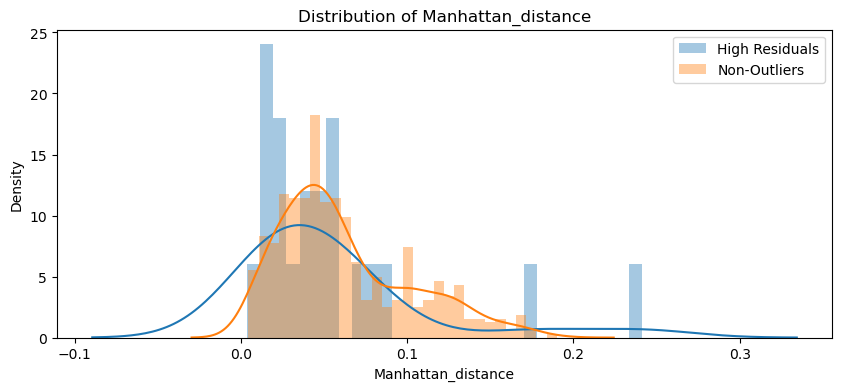

Feature: Manhattan_distance, KS Statistic: 0.243, P-Value: 0.155


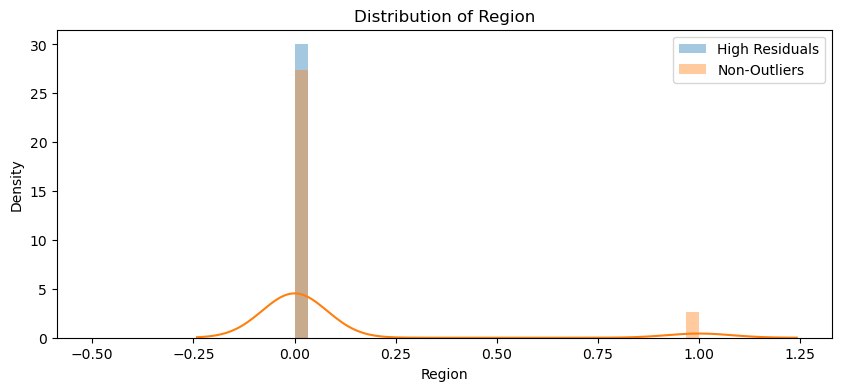

Feature: Region, KS Statistic: 0.086, P-Value: 0.995


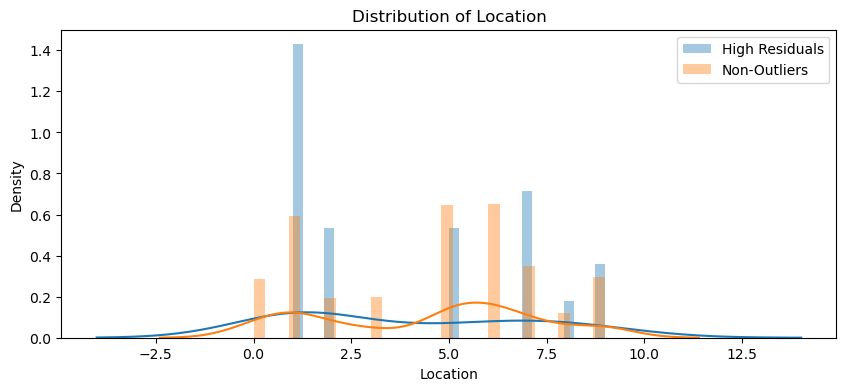

Feature: Location, KS Statistic: 0.202, P-Value: 0.335

Validation Set Analysis


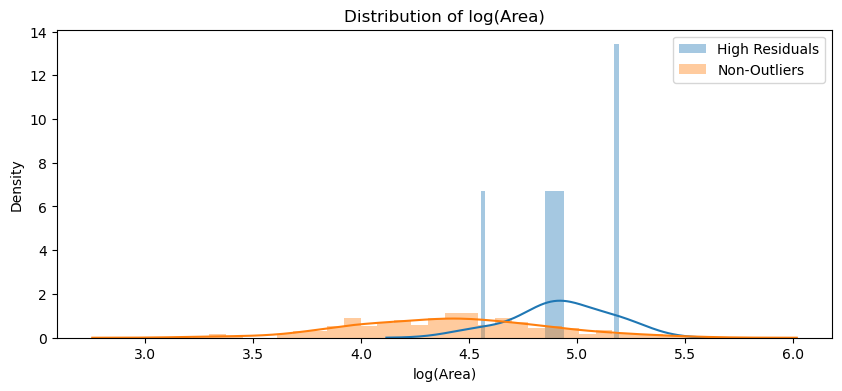

Feature: log(Area), KS Statistic: 0.702, P-Value: 0.001


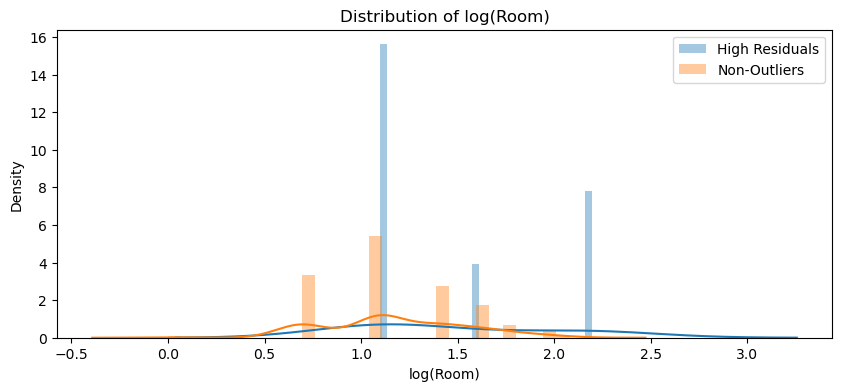

Feature: log(Room), KS Statistic: 0.286, P-Value: 0.543


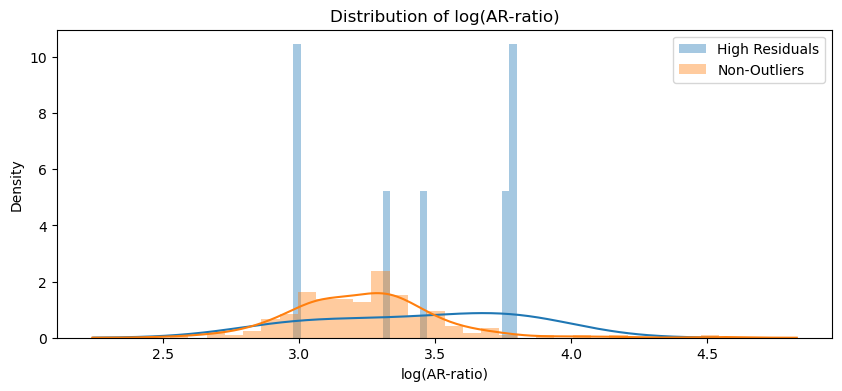

Feature: log(AR-ratio), KS Statistic: 0.411, P-Value: 0.152


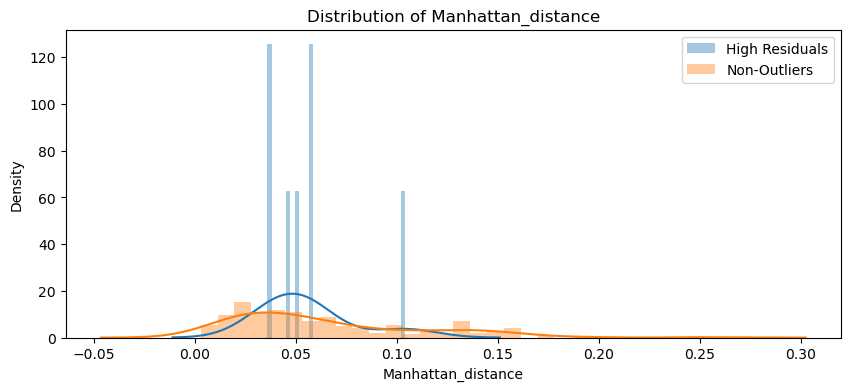

Feature: Manhattan_distance, KS Statistic: 0.345, P-Value: 0.325


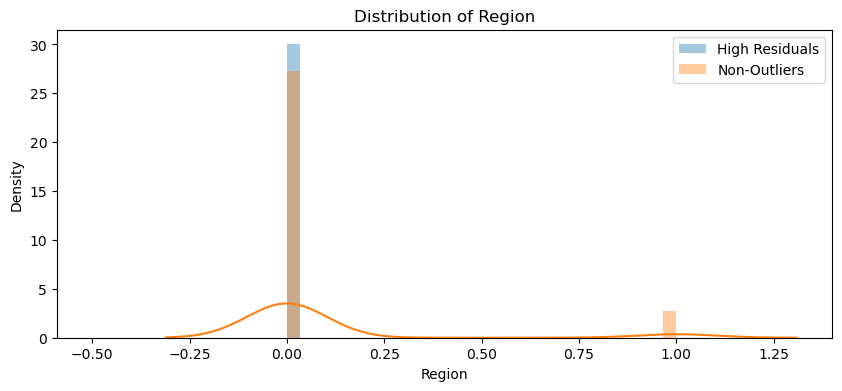

Feature: Region, KS Statistic: 0.092, P-Value: 1.000


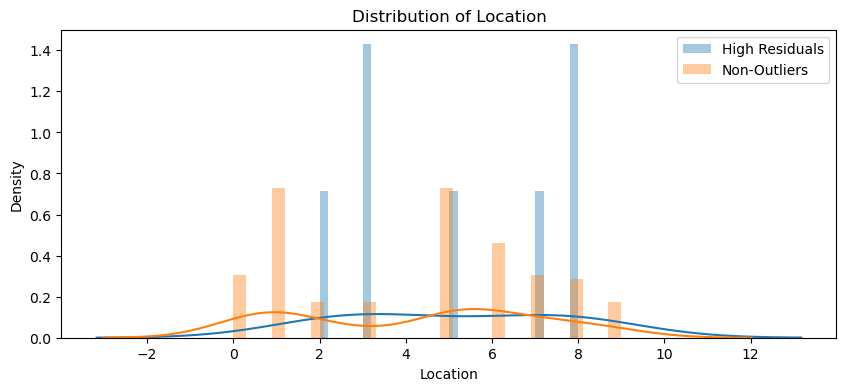

Feature: Location, KS Statistic: 0.310, P-Value: 0.449


In [13]:
# Function to identify observations with high residuals
def identify_high_residuals(residuals, features, n_std=2):
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    high_residual_threshold = mean_residual + n_std * std_residual

    # Identify observations with high residuals
    high_residuals_mask = residuals.abs() > high_residual_threshold
    high_residual_features = features[high_residuals_mask]
    non_outlier_features = features[~high_residuals_mask]

    return high_residual_features, non_outlier_features

# Function to plot feature distributions and perform statistical tests
def plot_and_test_features(high_residual_features, non_outlier_features):
    if high_residual_features.empty or high_residual_features.empty:
        print("Threshold too high, no high residuals found.")
        return None
    
    for feature in high_residual_features.columns:
        plt.figure(figsize=(10,4))
        sns.distplot(high_residual_features[feature], bins=30, kde=True, label='High Residuals', norm_hist=True)
        sns.distplot(non_outlier_features[feature], bins=30, kde=True, label='Non-Outliers', norm_hist=True)
        plt.legend()
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.show()

        # Perform Kolmogorov-Smirnov test to compare the distributions
        ks_stat, ks_p_value = stats.ks_2samp(high_residual_features[feature], non_outlier_features[feature])
        print(f"Feature: {feature}, KS Statistic: {ks_stat:.3f}, P-Value: {ks_p_value:.3f}")

# Apply the functions to the training set
print("Training Set Analysis")
train_high_residual_features, train_non_outlier_features = identify_high_residuals(Y_train["residuals"], X_train[features])
plot_and_test_features(train_high_residual_features, train_non_outlier_features)

# Apply the functions to the validation set
print("\nValidation Set Analysis")
val_high_residual_features, val_non_outlier_features = identify_high_residuals(Y_val["residuals"], X_val[features])
plot_and_test_features(val_high_residual_features, val_non_outlier_features)


**Final assessment**

**•** Summarize the findings and, if necessary, retrain a new model based on the new knowledge from the error analysis.


- Overview of current findings: 
    - The high residual cases were driven by data having a few rooms with large log(Area) values in the train set. This can be observed by by the shift of distribution to the right, when including outliers. 
    - However, this was not the case in validation set, despite outliers still present due to relatively large log(Area). 
    - Hence, the outliers may affect the accuracy of the model, and one should consider re-train the model after removing them. 

- Generate the [learning curve](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) to graphically represents the model's learning performance changes as the number of samples increases and assess if the model is underfitting, overfitting, or well-fitting .   

    - Learning curves can be used to diagnose if datasets are not representative of the problem domain.

- Finally, use this plot to evaluate whether collecting additional data can increare the model performance.

    - Collecting additional data can sometimes improve the performance of a machine learning model. However, there are cases where adding more data may not necessarily lead to better performance.


/Users/zaichen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zaichen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zaichen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zaichen/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 749, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zaichen/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)


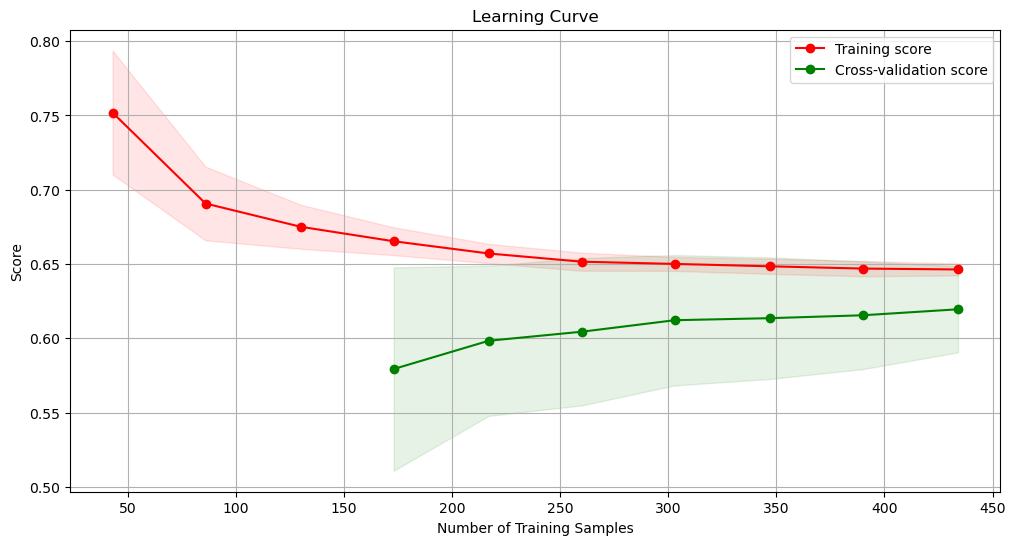

In [14]:
warnings.filterwarnings("ignore")
# Generate learning curves
cv = ShuffleSplit(n_splits=10, random_state=42,test_size=0.2)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=candidate_model,
    X=X_train,
    y=Y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=cv,
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation sets
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")

plt.fill_between(train_sizes, 
                 validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, 
                 alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()


- Train score: as observed by the red trend line, the train model performs well with a small number of samples. The decline in training score when the model is exposed to more data suggests that it's less able to fit the training set perfectly, likely due to increasing variance in the data.
- Cross validation score: as can be observed by the green line, it starts low but shows gradual increase when sample size increases, which is a good sign of generalisability. However, the gap between the two lines indicates that the training model is likely to overfit the train data, one could remove outliers in train set and observe the model performance change 
- Converging trend: this indicates adding more data could improve model generalisability,and that the model is learning effectively. The plateau trend also indicated there is no meaningful improvement of model performance when sample size increases. One could add more data to training set, and continuously track the CV score. 


In [39]:
# remove outliers in y_train by using the high_residual_features
X_train_cleaned= X_train.drop(index=train_high_residual_features.index)
Y_train_cleaned = Y_train.drop(index=train_high_residual_features.index)

#remove outliers in y_val by using the high_residual_features
X_val_cleaned = X_val.drop(index=val_high_residual_features.index)
Y_val_cleaned = Y_val.drop(index=val_high_residual_features.index)

# Fit the model on the cleaned training set 
candidate_model.fit(X_train_cleaned, Y_train_cleaned["Price"])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('Ridge', Ridge(alpha=0.2535151515151515))])

**•** Once the model performance is satisfactory, measure the generalization error using the *hold-out* / *test* set.

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train the model on the cleaned training set without outliers
candidate_model.fit(X_train_cleaned, Y_train_cleaned)

# Make predictions on the validation set without outliers
predictions = candidate_model.predict(X_val_cleaned)

# Calculate MSE, MAE, RMSE, and R² for the validation set without outliers
mse = mean_squared_error(Y_val_cleaned, predictions)
mae = mean_absolute_error(Y_val_cleaned, predictions)
rmse = np.sqrt(mse) 
r_squared = r2_score(Y_val_cleaned, predictions)

# Output the performance metrics
print(f"Mean Squared Error (MSE) on hold-out set: {mse}")
print(f"Root Mean Squared Error (RMSE) on hold-out set: {rmse}")
print(f"Mean Absolute Error (MAE) on hold-out set: {mae}")
print(f"R-squared (R²) on hold-out set: {r_squared}")


Mean Squared Error (MSE) on hold-out set: 9599543924.764164
Root Mean Squared Error (RMSE) on hold-out set: 97977.26228449213
Mean Absolute Error (MAE) on hold-out set: 57239.35440262806
R-squared (R²) on hold-out set: 0.6195149120626962
